In [1]:
#Import libraries needed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Enable inline plotting
%matplotlib inline


/Users/rodmurraysmith/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The speed/performance trade-off has been a staple topic for the HCI community, with much of the attention focussed on Fitts' law. Ch7 of (Schmidt & Lee, 2005) provides an excellent review.  Fitts proposed that the time ($MT$) to move to a target area is a function of the distance to the target ($A$) and the size of the target ($W$), 
$$
MT = a + b ID,
$$
where $ID$ is the Index of Difficulty
$$
ID = \log_2 \left(\frac{2A}{W}\right).
$$
Movement times and error rates are important aspects of human interaction, but they do not provide a complete picture.


-


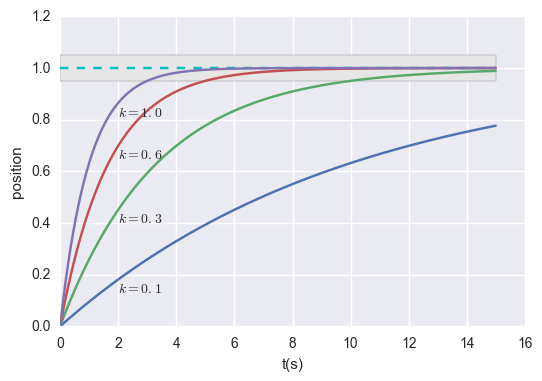

In [2]:
fig, ax = plt.subplots()

r = 1.0 # target centre
w = 0.1 # target width
k = 0.5
endT = 15
t = np.array(np.arange(0,endT,0.01))


# grey box indicating target area centred on r +/- w/2
verts = [(0, r-w/2)] + [(0, r+w/2)] + [(endT, r+w/2)]+[(endT, r-w/2)]
poly = mpl.patches.Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)
plt.plot(t,r*np.ones(len(t)),'c--'); # centre of target

# show response for a variety of gains k
for k in (0.1, 0.3, 0.6, 1.0):
    y = r*(1-np.exp(-k*t))
    plt.plot(t,y);
    ax.text(t[200],y[200]-0.05,'$k='+str(k)+'$')

plt.ylabel('position');
plt.xlabel('t(s)');

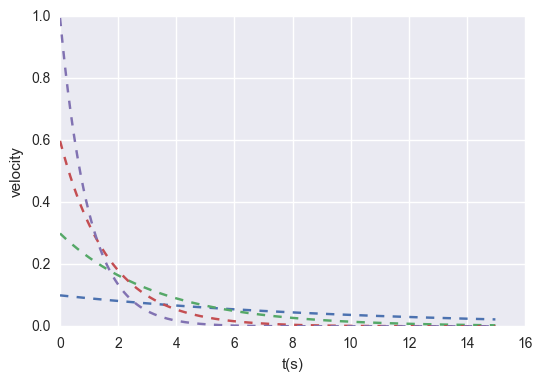

In [3]:
# show response for a variety of gains k
for k in (0.1, 0.3, 0.6, 1.0):
    y = r*(1-np.exp(-k*t))
    v = np.diff(y)/np.diff(t)
    plt.plot(t[0:-1],v,'--');
    ax.text(t[200],v[200]-0.05,'$k='+str(k)+'$')

plt.ylabel('velocity');
plt.xlabel('t(s)');

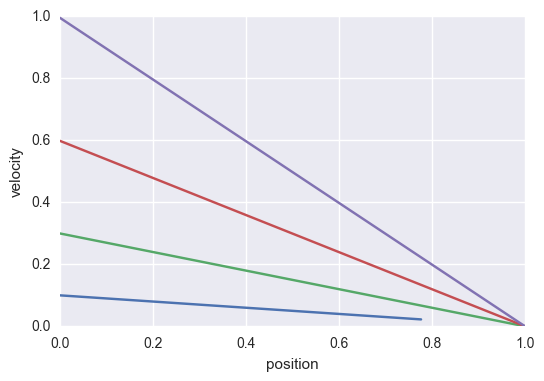

In [4]:
# show response for a variety of gains k
for k in (0.1, 0.3, 0.6, 1.0):
    y = r*(1-np.exp(-k*t))
    v = np.diff(y)/np.diff(t)
    plt.plot(y[0:-1],v);
    ax.text(y[100],v[100],'$k='+str(k)+'$');
    
plt.ylabel('velocity');
plt.xlabel('position');

Note that the trajectory in the phase space is a straight line -- this is because the control input is proportional ot the error between $y$ and $r$. 

Here we show some mouse movements captured while users performed a discrete Fitts' task. Generate some targetting data by moving left and right with your mouse or trackpad, then press esc to leave. Below you will see something like:
Logging data to: fitts_law_0015_log.csv
Change the code in 
X = pd.read_csv('fitts_law_0011_log.csv', names=['t','mx','cx','d0','d1'])
to use that filename.


Feel free to open fitts_law.py and edit the code to change the size of the targets (change TARGET_WIDTH constant). Try comparing results with a mouse and touchpad.

In [5]:
%cd  /Users/rodmurraysmith/SummerSchool2017/ComputationalInteraction17/Rod/Labs/
%run fitts_law.py  # press esc to quit

/Users/rodmurraysmith/SummerSchool2017/ComputationalInteraction17/Rod/Labs
Logging data to: fitts_law_0002_log.csv



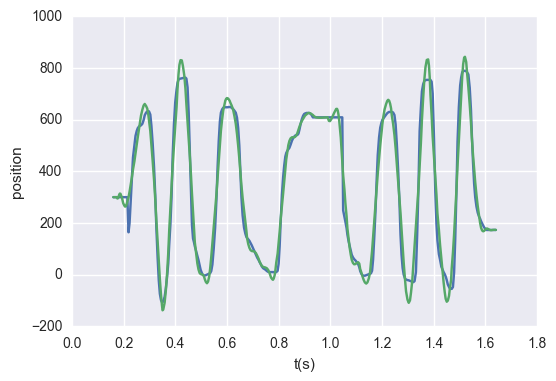

In [6]:
#load the data - feel free to record your own data here. Use the filename that appears when you execute the cell above
# e.g. Logging data to: fitts_law_0013_log.csv  - use fitts_law_0013_log.csv  below:
X = pd.read_csv('fitts_law_0002_log.csv', names=['t','mx','cx','d0','d1'])
thisT=range(10,len(X),1)
import scipy.signal
import scipy.stats

#filter the data to smooth it
y = scipy.signal.savgol_filter(X['d0'][thisT], 31, 4, mode="nearest")
plt.plot(X['t'][thisT],X['d0'][thisT]);
plt.plot(X['t'][thisT],y);
plt.ylabel('position');
plt.xlabel('t(s)');

If we want to plot a phase plot, we need the derivatives of the position data. Should we try just taking the differences?

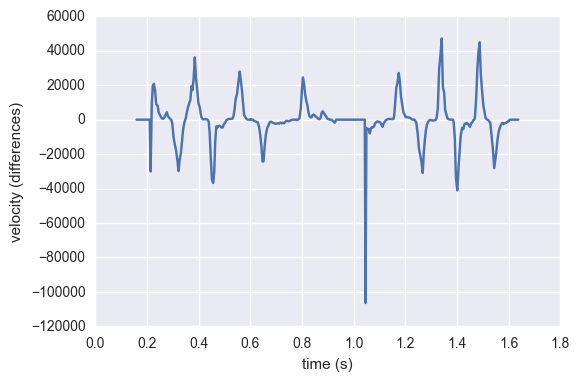

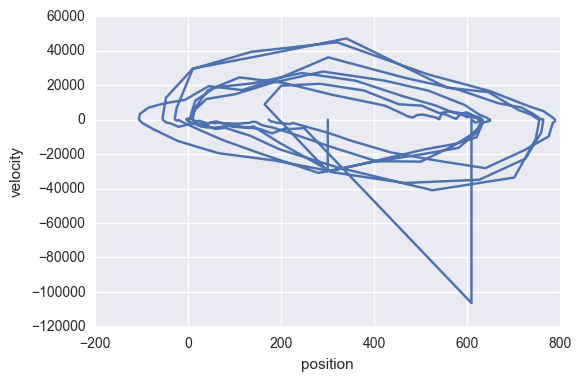

In [7]:
#get filtered derivatives
v = np.diff(X['mx'][thisT])/np.diff(X['t'][thisT])

plt.plot(X['t'][thisT[:-1]],v);
plt.xlabel('time (s)');
plt.ylabel('velocity (differences)')

plt.show();
plt.plot(X['d0'][thisT[:-1]],v);

plt.ylabel('velocity');
plt.xlabel('position');

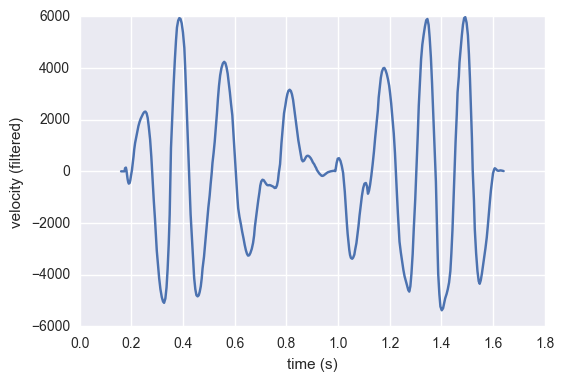

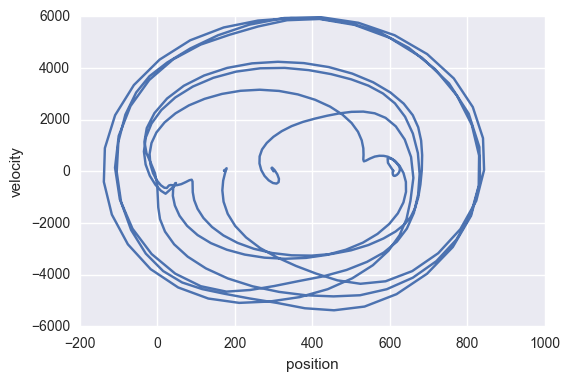

In [8]:
#get filtered derivatives
v = scipy.signal.savgol_filter(X['mx'][thisT], 31, 4, deriv=1, mode="nearest", delta=X['t'][2]-X['t'][1])
plt.plot(X['t'][thisT],v);
plt.xlabel('time (s)');
plt.ylabel('velocity (filtered)')
plt.show()

#np.diff(X['mx'][thisT])/np.diff(X['t'][thisT])

plt.plot(y,v);

plt.ylabel('velocity');
plt.xlabel('position');

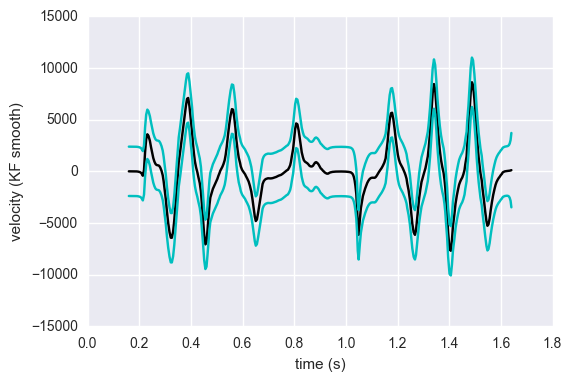

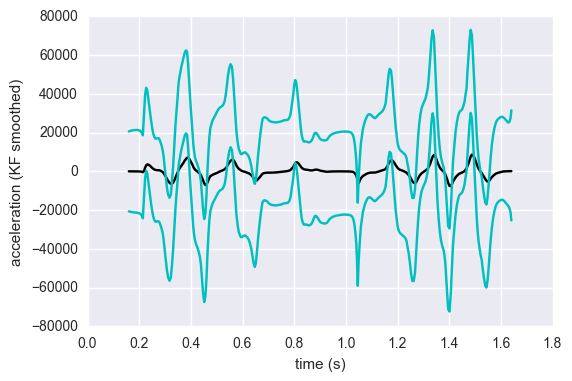

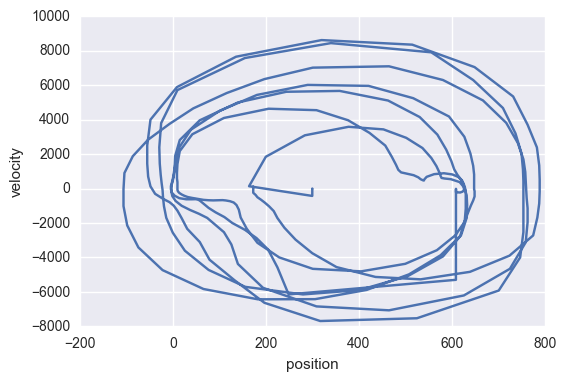

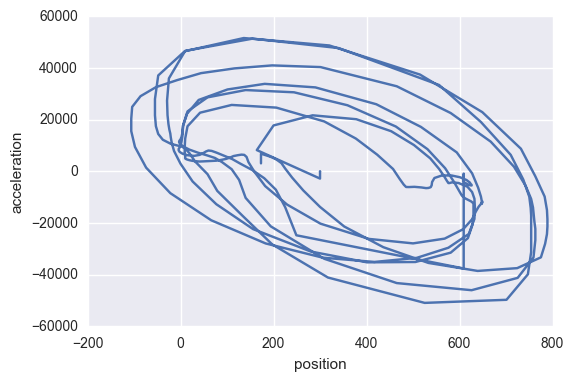

In [10]:
# try doing the same with the PyKalman package as in the earlier exercise.

import pykalman as pk
from pykalman import KalmanFilter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

noise =  0.1   # experiment with changing the initial estimate of the noise
Ts = X['t'][2]-X['t'][1]
measurements=X['d0'][:]

kf = KalmanFilter(transition_matrices = [[1, Ts, 0], [0, 1, Ts], [0, 0, 1]], observation_matrices = [[1, 0.0, 0.0]], observation_covariance = noise*noise, n_dim_obs=1)
# try not estimating the paramaters with EM
kf = kf.em(measurements, n_iter=15) # learn the parameters of the Kalman Filter
#(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

t= X['t'][thisT]

#note that we can now draw uncertainty bounds around the velocity estimates (here showing +/- 2 std deviations)
plt.plot(X['t'][thisT],smoothed_state_means[thisT,1],'-k', 
         X['t'][thisT],smoothed_state_means[thisT,1]+2*np.sqrt(smoothed_state_covariances[thisT,1,1]),'-c',
         X['t'][thisT],smoothed_state_means[thisT,1]-2*np.sqrt(smoothed_state_covariances[thisT,1,1]),'-c');
plt.xlabel('time (s)');
plt.ylabel('velocity (KF smooth)')
plt.show()

plt.plot(X['t'][thisT],smoothed_state_means[thisT,1],'-k', 
         X['t'][thisT],smoothed_state_means[thisT,2]+2*np.sqrt(smoothed_state_covariances[thisT,2,2]),'-c',
         X['t'][thisT],smoothed_state_means[thisT,2]-2*np.sqrt(smoothed_state_covariances[thisT,2,2]),'-c');
plt.xlabel('time (s)');
plt.ylabel('acceleration (KF smoothed)')
plt.show()

#np.diff(X['mx'][thisT])/np.diff(X['t'][thisT])

plt.plot(smoothed_state_means[thisT,0],smoothed_state_means[thisT,1]);
plt.ylabel('velocity');
plt.xlabel('position');
plt.show()
# how could you show the uncertainty on the phase plots?

# Draw a Hooke portrait
plt.plot(smoothed_state_means[thisT,0],smoothed_state_means[thisT,2]);
plt.ylabel('acceleration');
plt.xlabel('position');
plt.show()

#plt.plot(t, measurements[thisT], '.', t, smoothed_state_means[thisT][:],'-r')


Let's try extracting some higher derivatives from the position data - let's go for acceleration, and show that as a time series, and as a Hooke plot, with position.

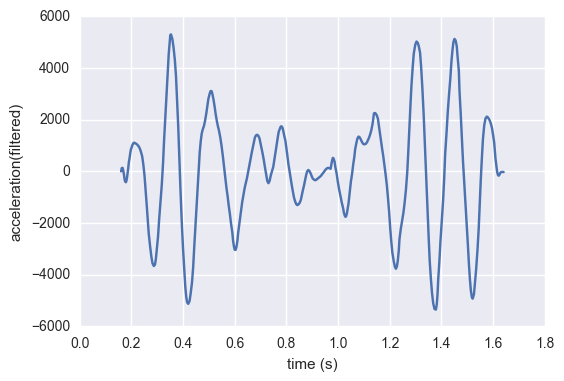

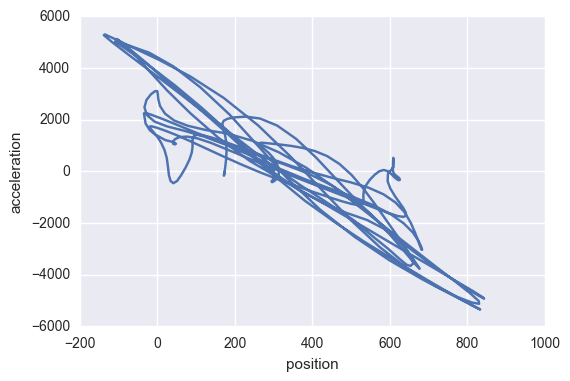

In [11]:
#get higher filtered derivatives - let's try acceleration this time
a = scipy.signal.savgol_filter(X['mx'][thisT], 41, 4, deriv=2, mode="nearest", delta=0.05)
plt.plot(X['t'][thisT],a);
plt.xlabel('time (s)');
plt.ylabel('acceleration(filtered)')
plt.show()

#np.diff(X['mx'][thisT])/np.diff(X['t'][thisT])

# Draw a Hooke portrait
plt.plot(y,a);

plt.ylabel('acceleration');
plt.xlabel('position');

Now try going back to the fitts_law.py code to sample some more data with different target sizes, and see if you replicate Bootsma's results showing the Hooke portrait changing as the Index of Difficulty is greater.


A second order model (e.g. damped spring-like systems) has slightly more complicated response form. For a second-order system with undamped natural frequency $\omega_n$ and a damping ratio $\zeta$
$$x(t) = r\left(1 - \frac{e^{-\zeta\omega_n t}}{\sqrt{1-\zeta^2}}\sin \left({\omega_n t\sqrt{1-\zeta^2} + \tan^{-1}\left(\frac{\sqrt{1-\zeta^2}}{\zeta}\right)}\right)\right).$$
Here we assume that the target capture occurs at maximum and minimum oscillation, so the sinusoidal aspect is disregarded, giving 
\begin{eqnarray*}
x(t) &=& r-\frac{1}{2}w\\
r\left(1 - \frac{e^{-\zeta\omega_n t}}{\sqrt{1-\zeta^2}}\right)& = & r-\frac{1}{2}w\\
\frac{e^{-\zeta\omega_n t}}{\sqrt{1-\zeta^2}} &=& \frac{w}{2r}\\
e^{-\zeta\omega_n t} &=& \sqrt{1-\zeta^2} \frac{w}{2r}\\
-\zeta\omega_n t &=& \ln {\sqrt{1-\zeta^2}} + \ln \frac{w}{2r}\\
t&=& \frac{-1}{\zeta \omega_n} \ln {\sqrt{1-\zeta^2}} + \frac{\ln 2}{\zeta \omega_n} \log_2 \frac{2r}{w}
\end{eqnarray*}
which again leads to a movement time which is a linear function of the $ID$, with the time constant of $\frac{1}{\zeta \omega_n}$. 


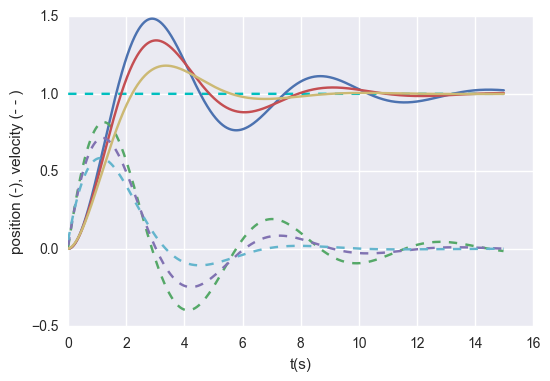

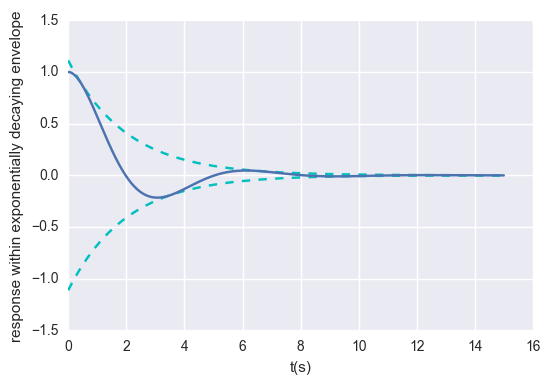

In [12]:

r = 1.0 # target centre
w = 0.1 # target width
k = 0.5
endT = 15
t = np.array(np.arange(0,endT,0.01))


# grey box indicating target area centred on r +/- w/2
verts = [(0, r-w/2)] + [(0, r+w/2)] + [(endT, r+w/2)]+[(endT, r-w/2)]
poly = mpl.patches.Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly);
plt.plot(t,r*np.ones(len(t)),'c--'); # centre of target

k1 = 1   # mass
k2 = 0.1 # damping
k3 = 1.3# spring constant

# show response for a variety of damping factors k2
# adjust this for k2 and k1 as well to explore the effects
for k2 in (0.5,0.7,1.0):
    omegan = np.sqrt(k1*k3)
    zeta = k2*np.sqrt(k1/k3)/2
    
    y = r*(1-np.exp(-omegan*zeta*t)/np.sqrt(1-zeta**2)*np.sin(omegan*t*(1-zeta**2)+np.arctan(np.sqrt(1-zeta**2)/zeta)))
    plt.plot(t,y);
    ax.text(t[200],y[200]-0.05,'$k2='+str(k)+'$')
    v = np.diff(y)/np.diff(t)
    plt.plot(t[0:-1],v,'--'); # plot velocities


plt.ylabel('position (-), velocity (- - )');
plt.xlabel('t(s)');

plt.figure()
omegan = np.sqrt(k1*k3)
zeta = k2*np.sqrt(k1/k3)/2
y0 = 1
if zeta < 1:
    plt.plot(t,y0/sqrt(1-np.power(zeta,2))*np.exp(-zeta*omegan*t),'c--', 
             t,-y0/sqrt(1-np.power(zeta,2))*np.exp(-zeta*omegan*t),'c--',
             t,y0/sqrt(1-np.power(zeta,2))*np.exp(-zeta*omegan*t)*np.sin(omegan*t*sqrt(1-np.power(zeta,2))+np.arccos(zeta)));
else:
    plt.plot(t,np.exp(-zeta*omegan*t));
    
plt.xlabel('t(s)');
plt.ylabel('response within exponentially decaying envelope');

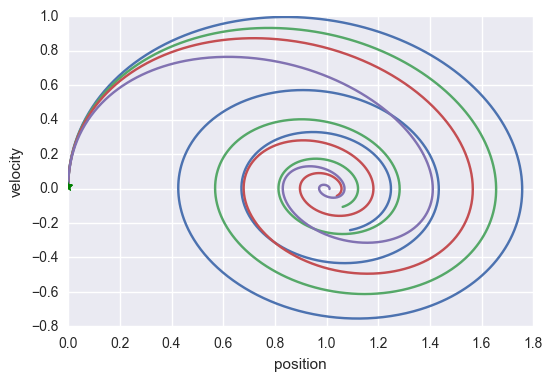

In [13]:
# show response for a variety of damping contstants k2
# experiment with other parameters

for k2 in (0.2,0.3,0.4,0.6): 
    omegan = np.sqrt(k1*k3)
    zeta = k2*np.sqrt(k1/k3)/2

    y = r*(1-np.exp(-omegan*zeta*t)/np.sqrt(1-zeta**2)*np.sin(omegan*t*(1-zeta**2)+np.arctan(np.sqrt(1-zeta**2)/zeta)))
    v = np.diff(y)/np.diff(t)
    plt.plot(y[0:-1],v);
    plt.plot(y[0],v[0],'g*')
    ax.text(y[200],v[200]-0.05,'$k='+str(k)+'$');

plt.ylabel('velocity');
plt.xlabel('position');

You can experiment with generating phase plots from your own movements. Press 'H' to see the keyboard commands that can be applied. You can track gestures, build classifiers.



In [1]:
%cd  /Users/rodmurraysmith/SummerSchool2017/ComputationalInteraction17/Rod/Labs/phase/
%run phase.py



/Users/rodmurraysmith/SummerSchool2017/ComputationalInteraction17/Rod/Labs/phase
No existing sequences file found!
No sequences to export
